## Style Transfer Using GAN

### Variables, Hyperparamaters and libraries import

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
#Import all the required libraries
%pip install pandas numpy tensorflow matplotlib imageio scikit-image
%pip install git+https://github.com/tensorflow/docs
import os
from os import listdir
import time
import glob
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import plot_model
import tensorflow_docs.vis.embed as embed

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-dsiav8ci
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-dsiav8ci
  Resolved https://github.com/tensorflow/docs to commit a8576cef38b7182e6228d7aafca8ef51754ab9e8
  Preparing metadata (setup.py) ... done


In [57]:
OUTPUT_FOLDER = './Output/'
TIMESTAMP = str(time.strftime('%Y%m%d%H%M%S'))
TEMP_FOLDER = OUTPUT_FOLDER + TIMESTAMP + '/'

if os.path.exists(OUTPUT_FOLDER):
    os.mkdir(TEMP_FOLDER)
else:
    os.mkdir(OUTPUT_FOLDER)
    os.mkdir(TEMP_FOLDER)

BUFFER_SIZE = 1000
BATCH_SIZE = 1


IMG_HEIGHT = 256
IMG_WIDTH = 256

### Data Initialization

In [58]:
# load and resize images
def load_images(path, size=(256,256)):
    data_list = list()

    for filename in listdir(path):
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store the data
        data_list.append(pixels)
    return asarray(data_list)

In [59]:
tr1_data = load_images('/content/drive/MyDrive/Upgrad-Capstone/MRI+T1_T2+Dataset/Tr1/TrainT1/')
tr2_data = load_images('/content/drive/MyDrive/Upgrad-Capstone/MRI+T1_T2+Dataset/Tr2/TrainT2/')

 #convert to grayscale
tr1_data = tf.image.rgb_to_grayscale(tr1_data)
tr2_data = tf.image.rgb_to_grayscale(tr2_data)

tr1= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr1_data))
tr2= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr2_data))

tr1

<_TensorSliceDataset element_spec=TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)>

In [60]:
tr2

<_TensorSliceDataset element_spec=TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)>

### Image Preprocessing

#### Image to Pixel conversion

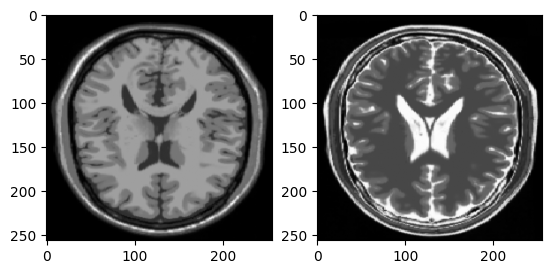

In [61]:
# Convert images to pixels and append it to a dataframe
fig, axs = plt.subplots(1,2)
axs[0].imshow(tr1_data[0], cmap='grey')
axs[1].imshow(tr2_data[0], cmap='grey')
plt.show();

#### Image Resizing & pixel Normalization

In [62]:
def normalize(image):
    image =  tf.cast(image, tf.float32)
    image= (image / 127.5) - 1
    return image

AUTOTUNE = tf.data.experimental.AUTOTUNE
tr1 = tr1.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tr2 = tr2.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


#### Image Reshaping, Shuffling and Batch Processing

In [63]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

#### Augmentation Tryouts

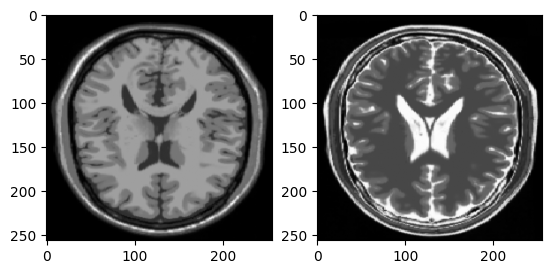

In [64]:
seed = (1, 2)
fig, axs = plt.subplots(1,2)

axs[0].imshow(tr1_data[0], cmap='grey')
axs[1].imshow(tr2_data[0], cmap='grey')
plt.show();


### Loss Functions & Optimizer

In [65]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

### Model Building

#### Instance Normalization

In [66]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling and Upsampling

In [67]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

#### Generator

In [68]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(64, 4, False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)


    ]
    up_stack = [
        upsample(512, 4, True),
        upsample(512, 4, True),
        upsample(512, 4, True),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [69]:
generator_g = unet_generator()
generator_f = unet_generator()

generator_g.summary()

Model: "functional_189"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_166     │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_156      │ (None, 128, 128,  │      1,024 │ input_layer_166[… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_157      │ (None, 64, 64,    │    131,328 │ sequential_156[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_158      │ (None, 32, 32,    │    524,800 │ sequential_157[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_159      │ (None, 16, 16,    │  2,098,176 │ sequential_158[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_160      │ (None, 8, 8, 512) │  4,195,328 │ sequential_159[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_161      │ (None, 4, 4, 512) │  4,195,328 │ sequential_160[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_162      │ (None, 2, 2, 512) │  4,195,328 │ sequential_161[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_163      │ (None, 4, 4, 512) │  4,195,328 │ sequential_162[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 128, 128,  │          0 │ sequential_163[0… │
│ (Concatenate)       │ 128)              │            │ sequential_161[0… │
│                     │                   │            │ sequential_164[0… │
│                     │                   │            │ sequential_160[0… │
│                     │                   │            │ sequential_165[0… │
│                     │                   │            │ sequential_159[0… │
│                     │                   │            │ sequential_166[0… │
│                     │                   │            │ sequential_158[0… │
│                     │                   │            │ sequential_167[0… │
│                     │                   │            │ sequential_157[0… │
│                     │                   │            │ sequential_168[0… │
│                     │                   │            │ sequential_156[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_164      │ (None, 8, 8, 512) │  8,389,632 │ concatenate_12[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_165      │ (None, 16, 16,    │  8,389,632 │ concatenate_12[1… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_166      │ (None, 32, 32,    │  4,194,816 │ concatenate_12[2… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 41,823,873 (159.55 MB)

 Trainable params: 41,823,873 (159.55 MB)

 Non-trainable params: 0 (0.00 B)

#### Discriminator

In [70]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='input_image')
    x = inp

    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
    down3 = downsample(256, 4)(down2) # (bs, 8, 8, 128)

    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) # (bs, 10, 10, 128)

    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7, 256)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)

    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [71]:
discriminator_x = discriminator()
discriminator_y = discriminator()

discriminator_x.summary()

Model: "functional_207"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_182 (Sequential)     │ (None, 128, 128, 64)   │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_183 (Sequential)     │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_20               │ (None, 66, 66, 128)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 63, 63, 512)    │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_170      │ (None, 63, 63, 512)    │         1,024 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_123 (LeakyReLU)     │ (None, 63, 63, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_21               │ (None, 65, 65, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 62, 62, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,190,145 (4.54 MB)

 Trainable params: 1,190,145 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

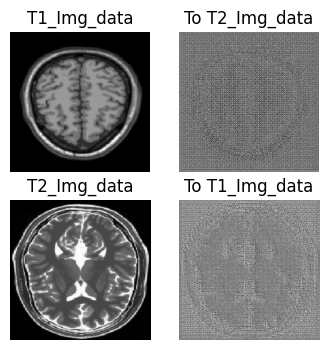

In [72]:
to_t2_img_data = generator_g(sample_tr1)
to_t1_img_data = generator_f(sample_tr2)
plt.figure(figsize=(4, 4))

imgs = [sample_tr1, to_t2_img_data, sample_tr2, to_t1_img_data]
title = ['T1_Img_data', 'To T2_Img_data', 'T2_Img_data', 'To T1_Img_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0], cmap='gray')
    plt.axis('off')
plt.show()

### Model Training

#### Checkpoint Initialization

In [73]:
checkpoint_path = TEMP_FOLDER +"Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [74]:

def generate_images(model1, test_input1, model2, test_input2, epoch):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig(TEMP_FOLDER +'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [75]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

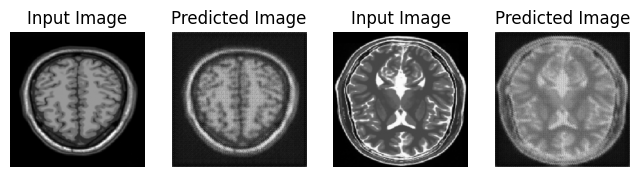

Saving checkpoint for epoch 1 at ./Output/20250503084954/Trained_Model/ckpt-1


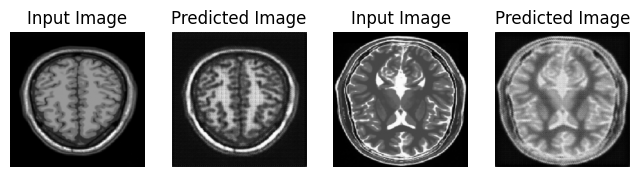

Saving checkpoint for epoch 2 at ./Output/20250503084954/Trained_Model/ckpt-2


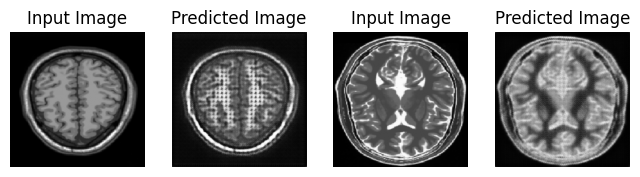

Saving checkpoint for epoch 3 at ./Output/20250503084954/Trained_Model/ckpt-3


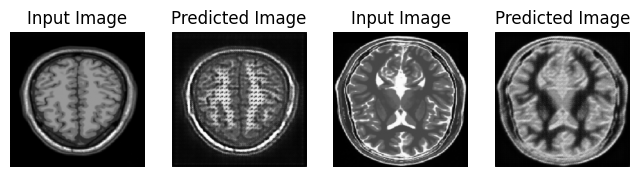

Saving checkpoint for epoch 4 at ./Output/20250503084954/Trained_Model/ckpt-4


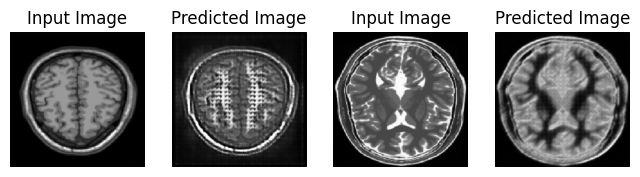

Saving checkpoint for epoch 5 at ./Output/20250503084954/Trained_Model/ckpt-5


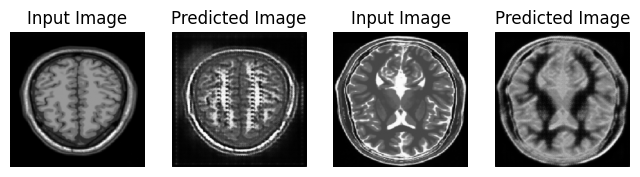

Saving checkpoint for epoch 6 at ./Output/20250503084954/Trained_Model/ckpt-6


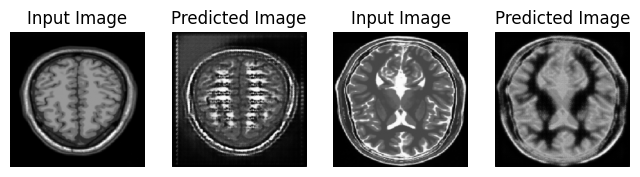

Saving checkpoint for epoch 7 at ./Output/20250503084954/Trained_Model/ckpt-7


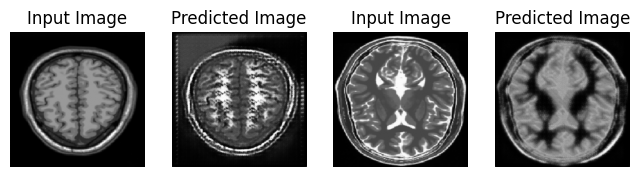

Saving checkpoint for epoch 8 at ./Output/20250503084954/Trained_Model/ckpt-8


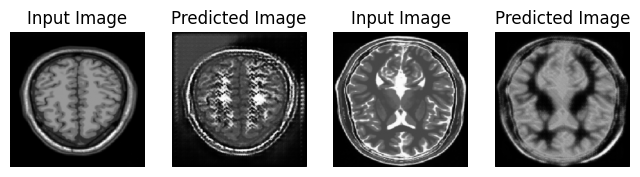

Saving checkpoint for epoch 9 at ./Output/20250503084954/Trained_Model/ckpt-9


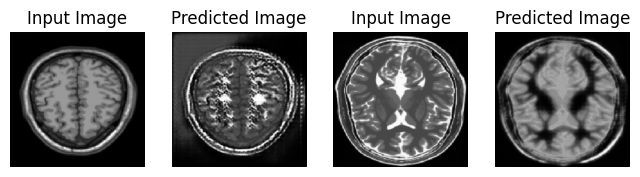

Saving checkpoint for epoch 10 at ./Output/20250503084954/Trained_Model/ckpt-10


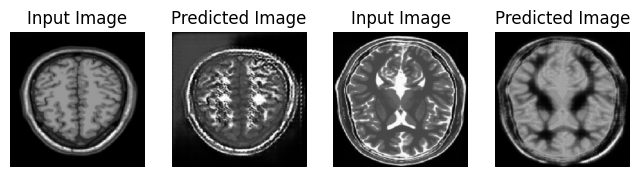

Saving checkpoint for epoch 11 at ./Output/20250503084954/Trained_Model/ckpt-11


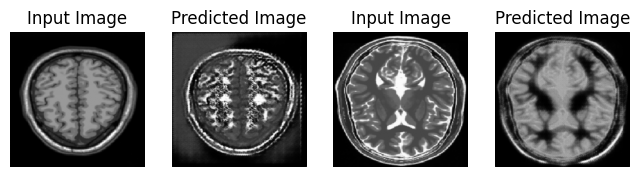

Saving checkpoint for epoch 12 at ./Output/20250503084954/Trained_Model/ckpt-12


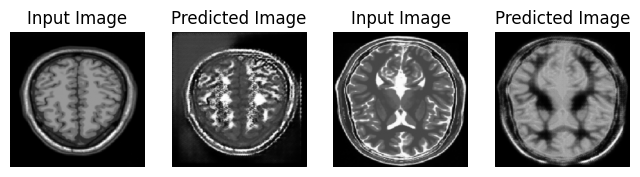

Saving checkpoint for epoch 13 at ./Output/20250503084954/Trained_Model/ckpt-13


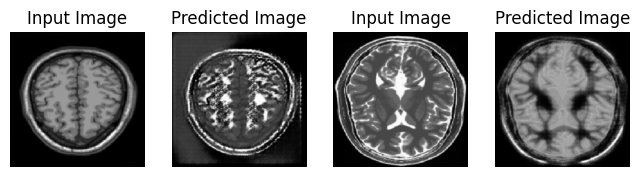

Saving checkpoint for epoch 14 at ./Output/20250503084954/Trained_Model/ckpt-14


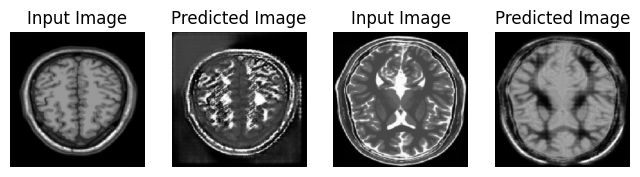

Saving checkpoint for epoch 15 at ./Output/20250503084954/Trained_Model/ckpt-15


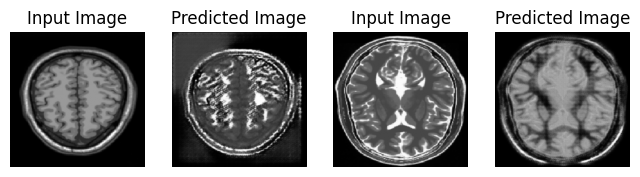

Saving checkpoint for epoch 16 at ./Output/20250503084954/Trained_Model/ckpt-16


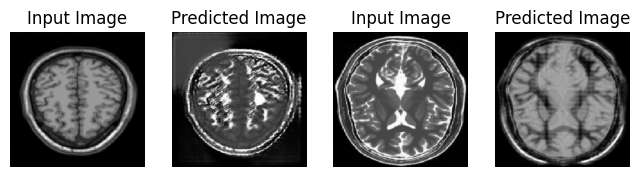

Saving checkpoint for epoch 17 at ./Output/20250503084954/Trained_Model/ckpt-17


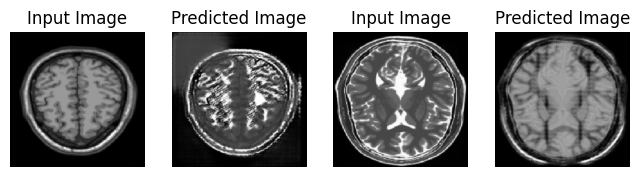

Saving checkpoint for epoch 18 at ./Output/20250503084954/Trained_Model/ckpt-18


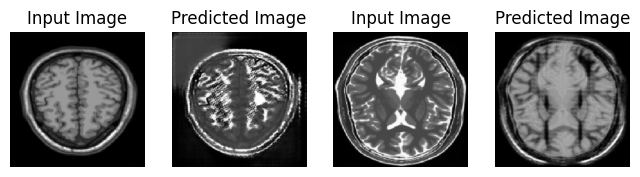

Saving checkpoint for epoch 19 at ./Output/20250503084954/Trained_Model/ckpt-19


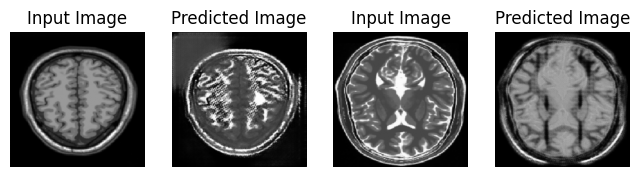

Saving checkpoint for epoch 20 at ./Output/20250503084954/Trained_Model/ckpt-20


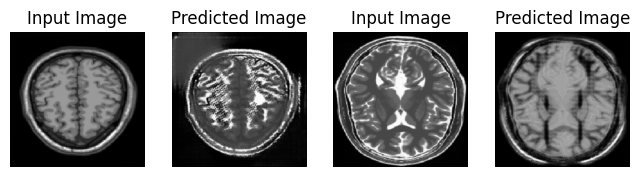

Saving checkpoint for epoch 21 at ./Output/20250503084954/Trained_Model/ckpt-21


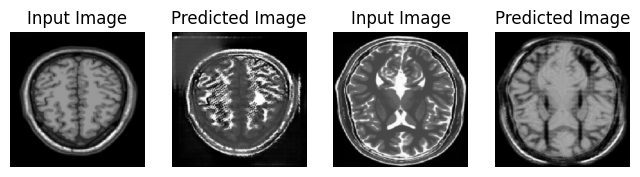

Saving checkpoint for epoch 22 at ./Output/20250503084954/Trained_Model/ckpt-22


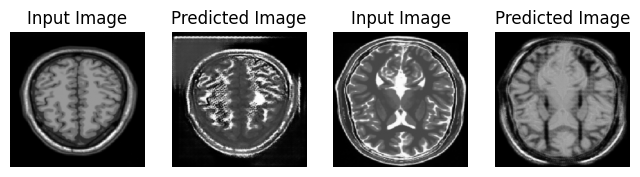

Saving checkpoint for epoch 23 at ./Output/20250503084954/Trained_Model/ckpt-23


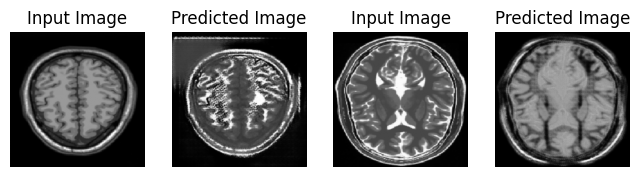

Saving checkpoint for epoch 24 at ./Output/20250503084954/Trained_Model/ckpt-24


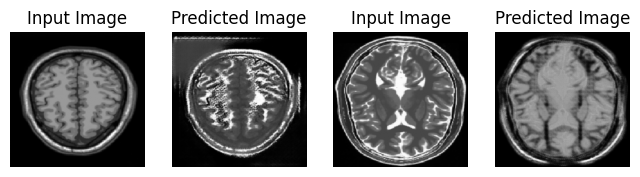

Saving checkpoint for epoch 25 at ./Output/20250503084954/Trained_Model/ckpt-25


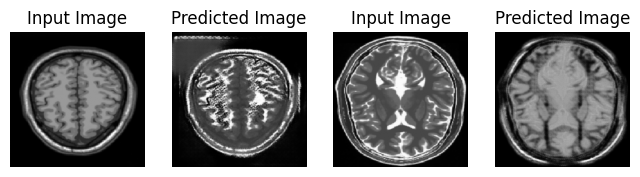

Saving checkpoint for epoch 26 at ./Output/20250503084954/Trained_Model/ckpt-26


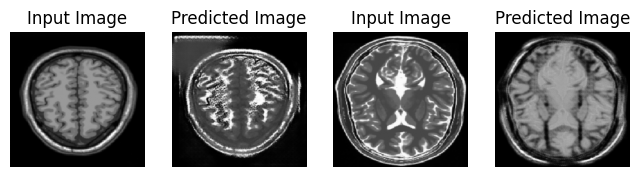

Saving checkpoint for epoch 27 at ./Output/20250503084954/Trained_Model/ckpt-27


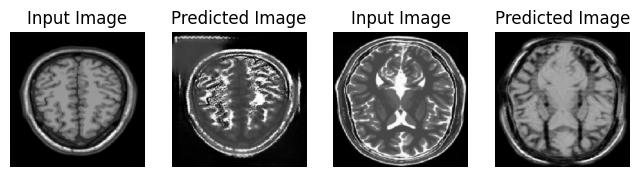

Saving checkpoint for epoch 28 at ./Output/20250503084954/Trained_Model/ckpt-28


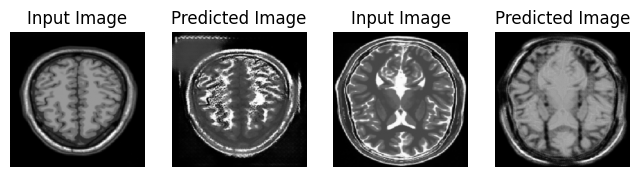

Saving checkpoint for epoch 29 at ./Output/20250503084954/Trained_Model/ckpt-29


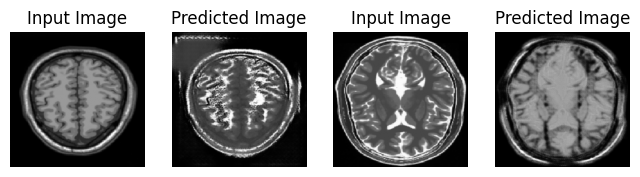

Saving checkpoint for epoch 30 at ./Output/20250503084954/Trained_Model/ckpt-30


In [76]:
for epoch in range(1, 30+1):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1, generator_f, sample_tr2, epoch)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

In [77]:
anim_file = TEMP_FOLDER + 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob( TEMP_FOLDER + 'image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-77-a5fa925ba11c>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-77-a5fa925ba11c>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



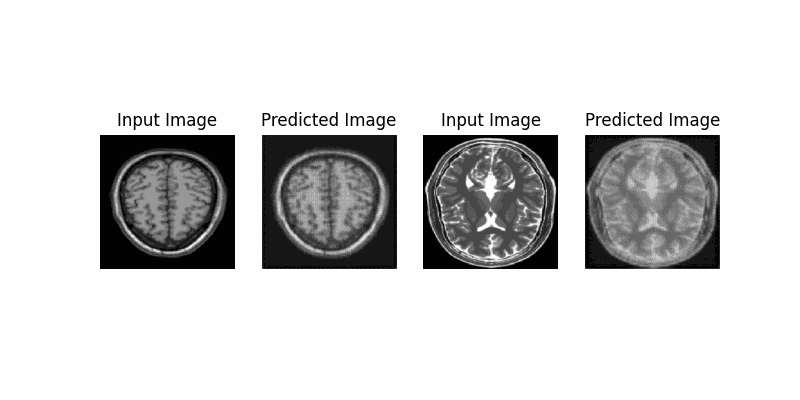

In [78]:
embed.embed_file(anim_file)